In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [13]:
# Fungsi untuk memuat dataset
def scan_and_load_images(base_folder, target_size=(128, 128)):
    # Data generator dengan rescaling saja (tanpa augmentasi)
    datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,
        validation_split=0.2  # 20% untuk validasi
    )

    # Generator untuk training
    train_generator = datagen.flow_from_directory(
        base_folder, 
        target_size=target_size,
        color_mode='rgb',
        batch_size=32,
        class_mode='categorical',  # Multi-class classification
        subset='training',
        shuffle=True
    )

    # Generator untuk validasi
    validation_generator = datagen.flow_from_directory(
        base_folder,
        target_size=target_size,
        color_mode='rgb',
        batch_size=32,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )

    return train_generator, validation_generator


In [14]:
# Path ke dataset
dataset_path = 'D:\\projek\\FIX\\drowsiness-detection\\new_test_processing'

In [15]:
# Panggil fungsi untuk memuat data
train_generator, validation_generator = scan_and_load_images(dataset_path)

# Print label mapping
print("Class indices:", train_generator.class_indices)


Found 2363 images belonging to 3 classes.
Found 589 images belonging to 3 classes.
Class indices: {'mengantuk': 0, 'menguap': 1, 'tidak_mengantuk': 2}


In [16]:
# Model MobileNet
def build_mobilenet_model(input_shape, num_classes):
    # Gunakan MobileNet tanpa pre-trained weights
    base_model = MobileNet(
        weights='imagenet',  # Tidak menggunakan pretrained weights
        include_top=False,
        input_shape=input_shape
    )
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Semua layer bisa dilatih karena tidak ada pretrained weights
    for layer in base_model.layers:
        layer.trainable = True

    return model


In [17]:
# Input shape dan jumlah kelas
input_shape = (128, 128, 3)
num_classes = 3  # mengantuk, menguap, tidak_mengantuk

In [18]:
# Inisialisasi model
model = build_mobilenet_model(input_shape, num_classes)

In [19]:
# Kompilasi model
model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [20]:
# Callback untuk early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [ ]:
# Training model
print("\n=== Training Model ===")
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=[early_stopping]
)



=== Training Model ===


Epoch 1/100



=== Evaluasi Model ===
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 836ms/step - accuracy: 0.1726 - loss: 0.9952
Validation Loss: 1.0307
Validation Accuracy: 0.4160
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 982ms/step
mengantuk: Optimal Threshold = 0.4238
menguap: Optimal Threshold = 0.1498
tidak_mengantuk: Optimal Threshold = 0.4263


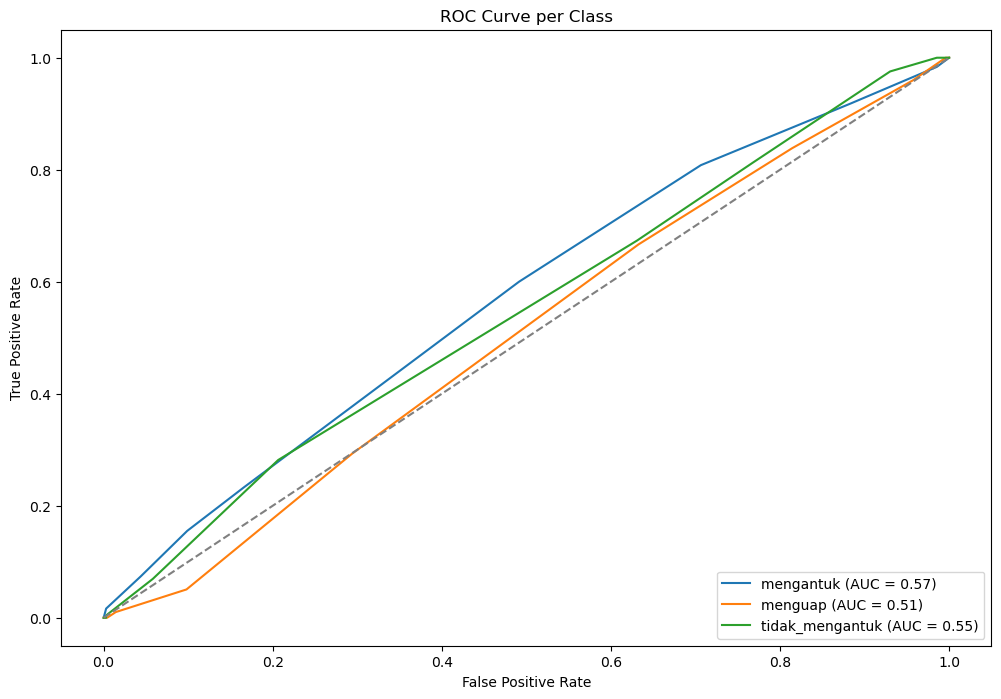

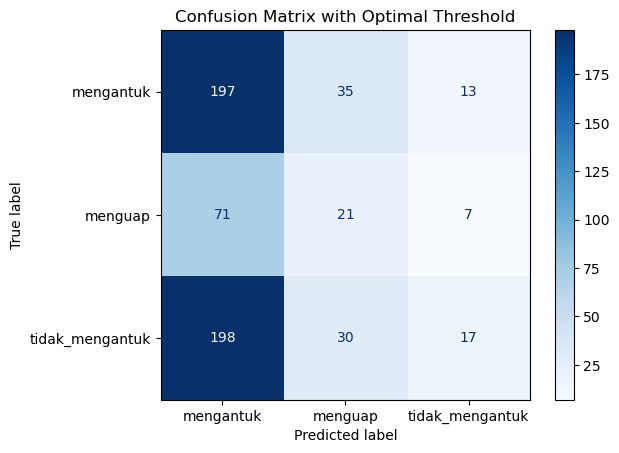


Classification Report (Optimal Threshold):
                 precision    recall  f1-score   support

      mengantuk       0.42      0.80      0.55       245
        menguap       0.24      0.21      0.23        99
tidak_mengantuk       0.46      0.07      0.12       245

       accuracy                           0.40       589
      macro avg       0.38      0.36      0.30       589
   weighted avg       0.41      0.40      0.32       589



In [36]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc

# Evaluasi dengan generator validasi
print("\n=== Evaluasi Model ===")
evaluation = model.evaluate(validation_generator)
print(f"Validation Loss: {evaluation[0]:.4f}")
print(f"Validation Accuracy: {evaluation[1]:.4f}")

# Confusion Matrix
validation_generator.reset()
y_probs = model.predict(validation_generator)
y_pred = np.argmax(y_probs, axis=1)
y_true = validation_generator.classes

# ROC Curve dan Optimal Threshold untuk setiap kelas
optimal_thresholds = []
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(train_generator.class_indices.keys()):
    fpr, tpr, thresholds = roc_curve((y_true == i).astype(int), y_probs[:, i])
    roc_auc = auc(fpr, tpr)

    # Cari threshold optimal
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    optimal_thresholds.append(optimal_threshold)

    # Plot ROC Curve
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
    print(f"{class_name}: Optimal Threshold = {optimal_threshold:.4f}")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Class')
plt.legend(loc='lower right')
plt.show()

# Update Prediksi Menggunakan Optimal Threshold
y_pred_optimal = np.zeros_like(y_probs)

# Terapkan threshold optimal untuk setiap kelas
for i, threshold in enumerate(optimal_thresholds):
    y_pred_optimal[:, i] = (y_probs[:, i] > threshold).astype(int)

# Pilih kelas dengan skor tertinggi setelah thresholding
y_pred_optimal_class = np.argmax(y_pred_optimal, axis=1)

# Confusion Matrix dengan threshold optimal
cm_optimal = confusion_matrix(y_true, y_pred_optimal_class)
disp_optimal = ConfusionMatrixDisplay(confusion_matrix=cm_optimal, display_labels=list(train_generator.class_indices.keys()))
disp_optimal.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix with Optimal Threshold")
plt.show()

# Classification Report dengan threshold optimal
print("\nClassification Report (Optimal Threshold):")
print(classification_report(y_true, y_pred_optimal_class, target_names=list(train_generator.class_indices.keys())))


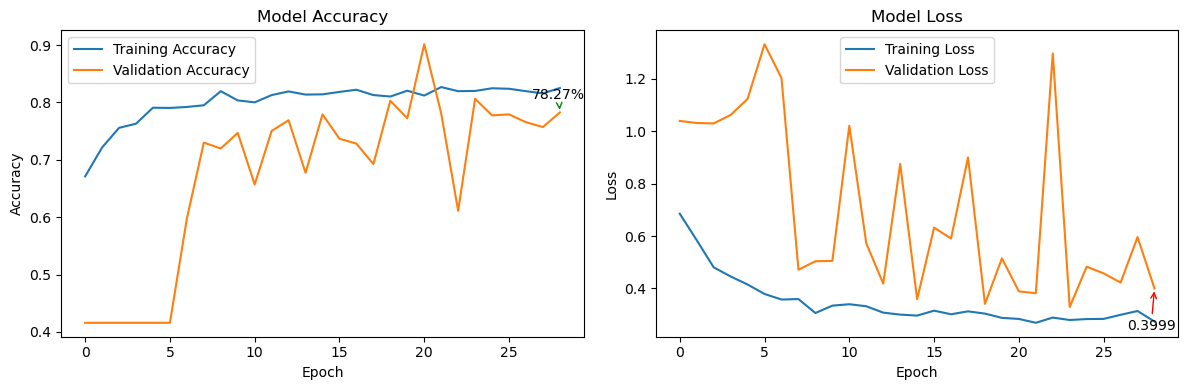

In [25]:
# Visualisasi hasil training
plt.figure(figsize=(12, 4))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Tambahkan anotasi akurasi validasi terakhir
final_val_accuracy = history.history['val_accuracy'][-1]
plt.annotate(f'{final_val_accuracy * 100:.2f}%', 
             xy=(len(history.history['val_accuracy']) - 1, final_val_accuracy), 
             xytext=(-20, 10), textcoords='offset points', 
             arrowprops=dict(arrowstyle='->', color='green'))

plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Tambahkan anotasi loss validasi terakhir
final_val_loss = history.history['val_loss'][-1]
plt.annotate(f'{final_val_loss:.4f}', 
             xy=(len(history.history['val_loss']) - 1, final_val_loss), 
             xytext=(-20, -30), textcoords='offset points', 
             arrowprops=dict(arrowstyle='->', color='red'))

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
